# Coding Tutorial 6: Supervised Learning, Cross Validation and Hyperparameter Tuning

In this coding tutorial we cover the following topics:

- Decision Trees
- Random Forests
- Hyperparameter Tuning with k-fold Cross Validation

## Decision Trees

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(634)

In [31]:
link = 'http://github.com/muhark/dpir-intro-python/raw/master/Week2/data/bes_data_subset_week2.feather'
df = pd.read_feather(link)

# Let's predict 'Age' as a function of the rest
features = ['region', 'Age', 'a03', 'e01', 'k01',
            'k02', 'k11', 'k06', 'k08', 'y01',
            'y03', 'y06', 'y08', 'y09', 'y11', 'y17']
# Refactoring e01: partisan self-id
df.loc[:, 'e01'] = df['e01'].apply(
    lambda x: int(x.split(' ')[0]) if x[0] in ''.join(list(map(str, list(range(10))))) else None)
labels = 'a02'
df = df[features+[labels]].dropna()
temp = pd.get_dummies(df[features])
feature_names = temp.columns.tolist()
X = temp.values

In [32]:
col_dict = {
    'region': 'Region',
    'Age': 'Age',
    'a02': 'Which party is best able to handle this issue?',
    'a03': 'How interested are you in politics?',
    'e01': 'Left-Right Self-Placement',
    'k01': 'Attention to Politics',
    'k02': 'Reads politics news',
    'k11': 'Contacted by canvasser',
    'k06': 'Uses Twitter',
    'k08': 'Uses Facebook',
    'y01': 'Income bracket',
    'y03': 'Housing type',
    'y06': 'Religion',
    'y08': 'Trade Union Membership',
    'y09': 'Gender',
    'y11': 'Ethnicity',
    'y17': 'Employment type'
}

In [40]:
label_names = df.a02.cat.categories.tolist()
cat_int_map = dict(zip(label_names, range(12)))
cat_int_map

{'Refused': 0,
 'Don`t know': 1,
 'None/No party': 2,
 'Labour': 3,
 'Conservatives': 4,
 'Liberal Democrats': 5,
 'Scottish National Party (SNP)': 6,
 'Plaid Cymru': 7,
 'Green Party': 8,
 'United Kingdom Independence Party (UKIP)': 9,
 'Other': 10,
 'All of them/ more than one': 11}

In [33]:
y = df[labels].map(cat_int_map).astype(int).values

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [38]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10)
dt = dt.fit(X, y)

In [51]:
feature_names_long = [f.replace(f.split('_')[0], col_dict[f.split('_')[0]]) for f in feature_names]

In [52]:
r = export_text(dt, feature_names=feature_names_long)
print(r)

|--- Left-Right Self-Placement <= 4.50
|   |--- Region_Scotland <= 0.50
|   |   |--- How interested are you in politics?_Very interested <= 0.50
|   |   |   |--- Age <= 31.50
|   |   |   |   |--- Income bracket_GBP 50,000 - GBP 59,999 <= 0.50
|   |   |   |   |   |--- Region_North West <= 0.50
|   |   |   |   |   |   |--- How interested are you in politics?_Fairly interested <= 0.50
|   |   |   |   |   |   |   |--- Age <= 20.50
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- Age >  20.50
|   |   |   |   |   |   |   |   |--- Contacted by canvasser_No <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Contacted by canvasser_No >  0.50
|   |   |   |   |   |   |   |   |   |--- Employment type_Working part time - employee (8-29 hours) <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |   |--- Employment type_Working part time - employee (8-29 hours) >  0.50
|   |   |   |   |

## Random Forests

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
feature_importances = pd.DataFrame(
    data = {
        "features":  [col_dict[f.split('_')[0]] for f in feature_names],
        "importance": rf.feature_importances_
    }
)

feature_importances = feature_importances.groupby(['features'])[['importance']].sum().sort_values('importance').reset_index()
feature_importances

,features,importance
0,Uses Twitter,0.020176
1,Trade Union Membership,0.022174
2,Uses Facebook,0.027347
3,Ethnicity,0.028560
4,Reads politics news,0.029785
5,Contacted by canvasser,0.033800
6,Gender,0.034563
7,How interested are you in politics?,0.055021
8,Housing type,0.058485
9,Religion,0.069792


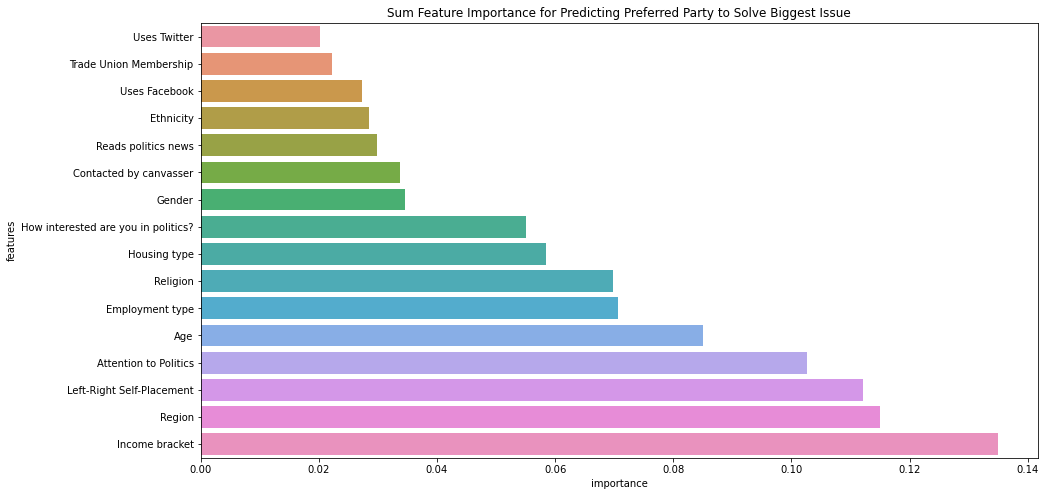

In [77]:
f, ax = plt.subplots(1,1, figsize=(15, 8))
ax.set_title("Sum Feature Importance for Predicting Preferred Party to Solve Biggest Issue")
sns.barplot(data = feature_importances, x='importance', y='features', ax=ax);

# Training-Test Split

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1410, 116) (1410,)
(470, 116) (470,)


In [81]:
def correct_prediction_rate(model, X_test, y_test):
    "Returns rate of correct predictions."
    preds = model.predict(X_test)
    correct_preds =  sum(preds == y_test)
    cpr = correct_preds/len(y_test)
    return cpr

In [82]:
rf_OOS = RandomForestClassifier()
rf_OOS.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
print(correct_prediction_rate(rf_OOS, X_test, y_test)) 

0.4851063829787234


In [84]:
print(correct_prediction_rate(rf, X_test, y_test))
print(correct_prediction_rate(rf_OOS, X_train, y_train))

1.0
1.0


# Hyperparameter Tuning

In [85]:
from sklearn.model_selection import RandomizedSearchCV

In [86]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [87]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
 }

In [88]:
rf = RandomForestClassifier()

rf_tuning = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    n_jobs=-1
)

rf_tuning.fit(X_train, y_train)

/home/lunayneko/anaconda3/envs/teaching/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [89]:
rf_tuning.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [90]:
correct_prediction_rate(
        rf_tuning.best_estimator_,
        X_test,
        y_test
    )

0.48936170212765956

In [91]:
# Compare OOS accuracy
"{:.3f}%".format(100*(
    correct_prediction_rate(
        rf_tuning.best_estimator_,
        X_test,
        y_test
    )-correct_prediction_rate(
        rf_OOS,
        X_test,
        y_test
    ))
) + " prediction accuracy improvement achieved!"

'0.426% prediction accuracy improvement achieved!'